In [ ]:
coord = 100,100,30
pad_width = [(0, max(0, coord[2-i] - slice.shape[i])) for i in range(3)]
p = np.pad(slice, pad_width=pad_width, mode='constant', constant_values=0)
np.all(p == slice)

True

In [22]:
from datatsets_peter import DICOMNodule, NRRDNodule,  ras_to_lps
nodule = DICOMNodule(
                         image_file_path="/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_35/",
                         center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
)

In [23]:
import SimpleITK as sitk
nrrdnodule = NRRDNodule(image_file_path="test.nrrd", center_lps=ras_to_lps([51.4106, -46.4581, -142.25]))

In [ ]:
from datatsets_peter import *
from datasets import getCtRawNodule
infos = NoduleInfoGenerator()
infos.add_strategies(R17SampleGeneratorStrategy, PrasadSampleGeneratoryStrategy)
infos = infos.generate_all_samples()


AttributeError: module 'numpy' has no attribute 'typing'

In [19]:
# n = [n for n in infos if n.file_path == "/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_6"][0] # 257
infos = getNoduleInfoList()
n = [n for n in infos if n.nod_id == "RIA_17-353D_Prasad_000_76"][0]
nodule = n.image_type(n.file_path, n.center_lps)

2024-07-31 19:41:25,353 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 26
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 29
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 61
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 69
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 103
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 128


IndexError: list index out of range

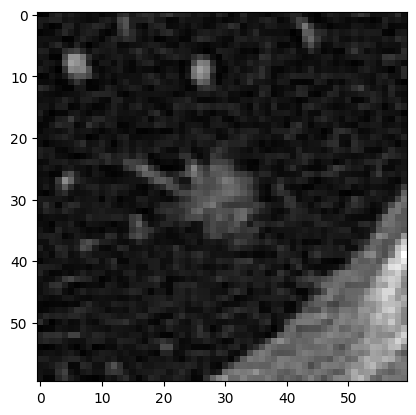

In [ ]:
import matplotlib.pyplot as plt
nod, _ = getCtRawNodule(n.file_path, n.image_type, n.center_lps, (60,60,60), False)
original, _ = nodule.nodule_slice(preprocess=False)
plt.imshow(original[30,:,:], cmap="gray")

Slice shape (60, 100, 100)


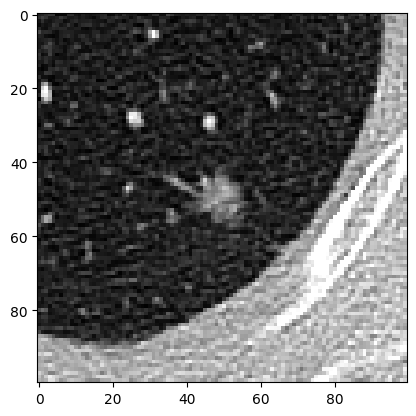

In [ ]:
print("Slice shape", sliced_arr.shape)
sliced_arr = np.clip(sliced_arr, -1400, 1400)
plt.imshow(sliced_arr[30,:,:], cmap="gray")

In [1]:
from datasets import getNoduleInfoList, slice_and_pad_segmentation, getCtRawNodule
noduleInfo_tup = getNoduleInfoList()[0]
width_irc = (40, 40, 30)
nodule_a, slice_3d = getCtRawNodule(
                noduleInfo_tup.file_path,
                noduleInfo_tup.image_type,
                noduleInfo_tup.center_lps,
                width_irc,
                preprocess=False
            )
nod_segmentation = slice_and_pad_segmentation("nodule", noduleInfo_tup, width_irc, slice_3d)

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 14:33:00,555 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 26
2024-08-01 14:33:00,558 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 29
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 61
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 69
2024-08-01 14:33:00,560 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 103
2024-08-01 14:33:00,561 INFO     pid:

In [1]:
from datasets import getNoduleInfoList
nods = getNoduleInfoList()

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 26
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 29
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 61
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 69
2024-08-01 19:30:19,279 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 103
2024-08-01 19:30:19,279 INFO     pid:

In [2]:
len(nods)

109

In [7]:
train = ['/data/etay/lung_hist_dat/original_dat_nrrds/nod44.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod98.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod88.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod85.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod114.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod143.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod68.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod162.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod22.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod116.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod8.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod43.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod175.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod160.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod123.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod94.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod53.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod5.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod132.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod72.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod74.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod84.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod173.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod173.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod48.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod36.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod12.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod3.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod54.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod83.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod18.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod23.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod19.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod71.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod82.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod151.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod45.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod139.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod11.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod1.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod167.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod6.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod47.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod46.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod63.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod119.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod147.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod80.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod89.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod131.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod31.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod67.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod39.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod112.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod109.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod104.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod86.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod76.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod28.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod164.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod130.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod50.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod21.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod15.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod9.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod100.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod138.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod32.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod111.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod16.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod108.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod63.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod55.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod62.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod178.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod49.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod43.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod87.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod73.nrrd']
val = ['/data/etay/lung_hist_dat/original_dat_nrrds/nod17.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod30.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod97.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod41.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod56.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod150.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod185.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod77.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod136.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod129.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod65.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod77.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod113.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod156.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod57.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod105.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod25.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod40.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod33.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod90.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod96.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod127.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod157.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod169.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod35.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod24.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod42.nrrd']
train = set(train)
val = set(val)
train.intersection(val)

set()

In [70]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
nodule = sitk.ReadImage("/data/etay/lung_hist_dat/original_dat_nrrds/nod104.nrrd")
seg = sitk.ReadImage("/data/kaplinsp/test_nnunet/lung_104.nii.gz")

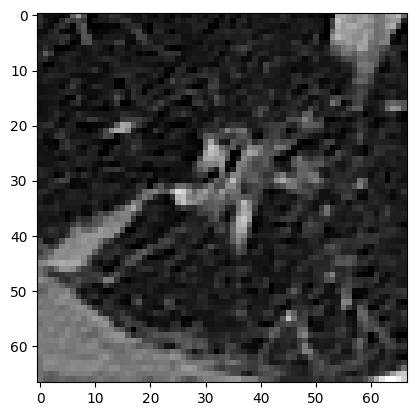

In [73]:
# plt.imshow(sitk.GetArrayFromImage(dilated_binary_image)[112, :, :], cmap="grey")
label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
dilation_in_mm = 5
signed_distance_map = sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True)
dilated_binary_image = (signed_distance_map<dilation_in_mm)
label_shape_filter.Execute(dilated_binary_image)
bounding_box = label_shape_filter.GetBoundingBox(1) 
p1 = dilated_binary_image.TransformIndexToPhysicalPoint(bounding_box[0 : int(len(bounding_box) / 2)])
p2 = dilated_binary_image.TransformIndexToPhysicalPoint([x+sz for x,sz in zip(bounding_box[0 : int(len(bounding_box) / 2)], bounding_box[int(len(bounding_box) / 2) :])])

# crop using the indexes computed for imgB
imgB_start_index = nodule.TransformPhysicalPointToIndex(p1)
imgB_end_index = nodule.TransformPhysicalPointToIndex(p2)
sliced = sitk.GetArrayFromImage(nodule)[slice(imgB_start_index[2], imgB_end_index[2]),slice(imgB_start_index[1], imgB_end_index[1]),slice(imgB_start_index[0], imgB_end_index[0])]
plt.imshow(sliced[8], cmap="grey")

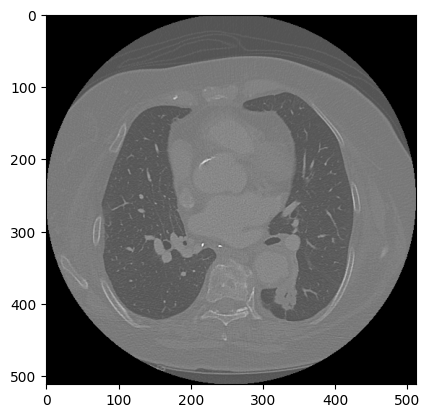

In [54]:
plt.imshow(sitk.GetArrayFromImage(nodule)[120], cmap="grey")